# Clusterings
---
From here, we want to determine if there are groups which form in terms of both the trend of responses given for questions about motivators and to see if groupings form from the students based on their response to what motivates them.

In [126]:
# Import the appropriate packages

# Data organization"
import numpy  as np
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
custom_style = {"axes.spines.right": False, "axes.spines.top": False,}
sns.set_style("ticks", rc=custom_style)

# Clustering packages
from sklearn               import preprocessing
from sklearn.cluster       import KMeans
from sklearn.decomposition import PCA
from scipy.cluster         import hierarchy
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [127]:
# Read in the data
df = pd.read_csv("cleaned_data.csv")

# Get a dataframe of just the questions of motivators
motivator_cols = df.columns[df.columns.str.contains('motivator')].tolist()

motivators = df[motivator_cols]

# Principal Component Analysis
---
PCA is a form of statistical modeling which reduces helps to reduce the dimensionality of the data by applying Matrix Operations to create vectors of the linear combination of parameters (in our case, motivators) which explain as much variability of the data as it cans. 

Each Principal Component explains a proportion of the variability (meaning this feature accounts for the much change of the data) in decreasing fashion so Principal Component 1 is guaranteed to contain the most amount of variability and so on.

#### Group of Motivators
---
For the first clustering, we will be accessing the groups which form from the questions we had asked themselves.

In [128]:
# Store the original name of the columns
motivator_names = motivators.columns

In [129]:
# Transpose the data so that each row is a question
motivator_features = motivators.T

# Scale the data
motivator_features = preprocessing.scale(motivator_features)

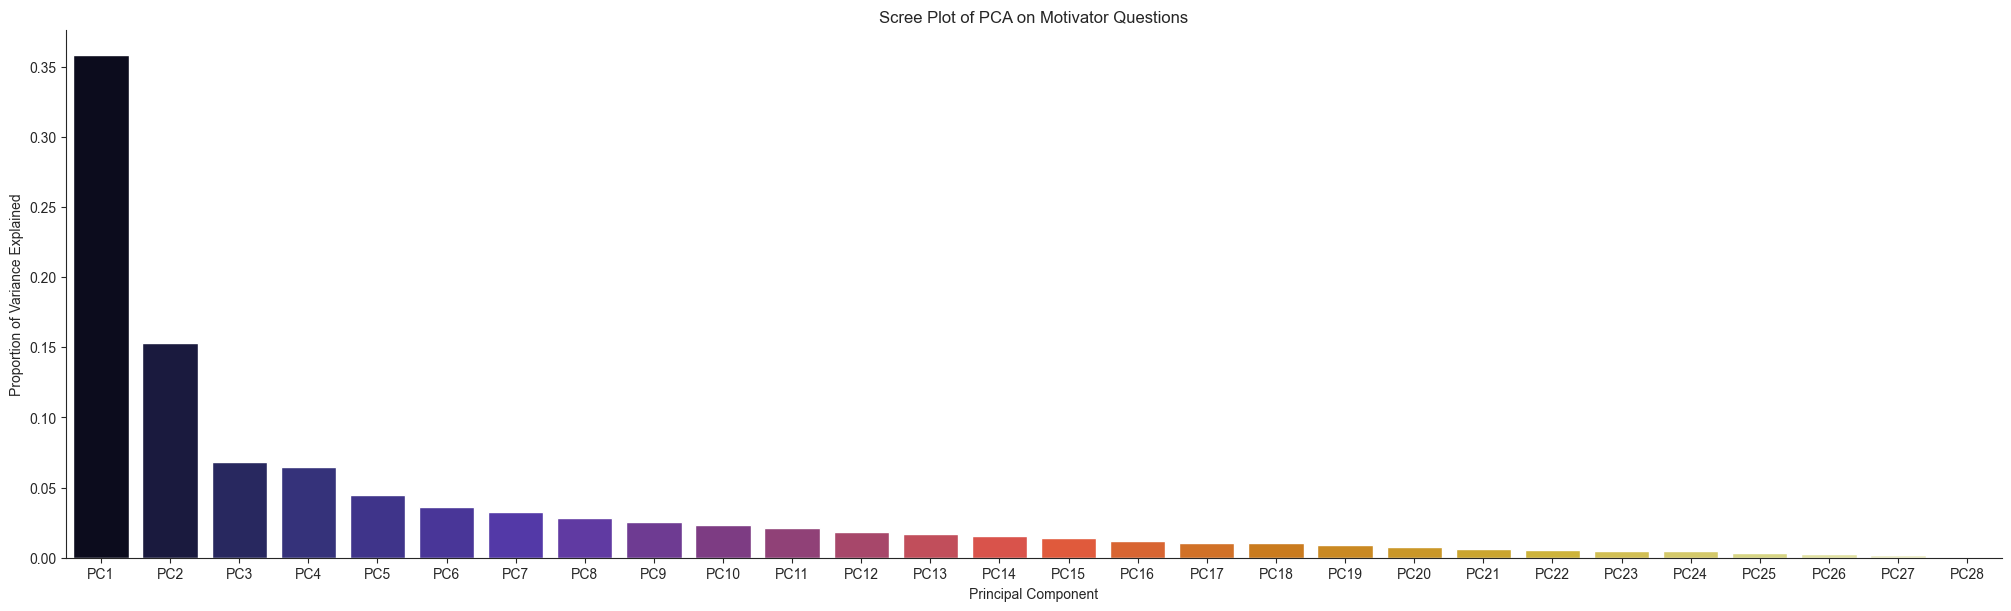

In [130]:
# Fit the PCA object to the data
pca_questions = PCA()
pca_questions.fit(motivator_features)

# Transform the data
motivator_features_pca = pca_questions.transform(motivator_features)

# Plot the scree plot

# Get the explained variance ratio
variance_ratio = pca_questions.explained_variance_ratio_
pca_labels = ['PC' + str(x) for x in range(1, len(variance_ratio)+1)]

# Plot the explained variance ratio
plt.figure(figsize=(20, 6), constrained_layout=True)
sns.barplot(x=pca_labels, y=variance_ratio, palette='CMRmap')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot of PCA on Motivator Questions')
plt.show()

In [131]:
# Calculate how many PCAs we need to explain 90% of the variance
cumulative_variance = np.cumsum(variance_ratio)
print('Number of PCAs needed to explain 80% of the variance:', np.argmax(cumulative_variance > 0.8) + 1)

Number of PCAs needed to explain 80% of the variance: 9


In [132]:
# Remove the 'motivator_' from the list of column names
short_name = [x.replace('motivator_', '') for x in motivator_names]

# Create a dataframe of the PCA loadings for the questions
ques_loadings = pd.DataFrame(motivator_features_pca, columns=pca_labels, index=short_name)

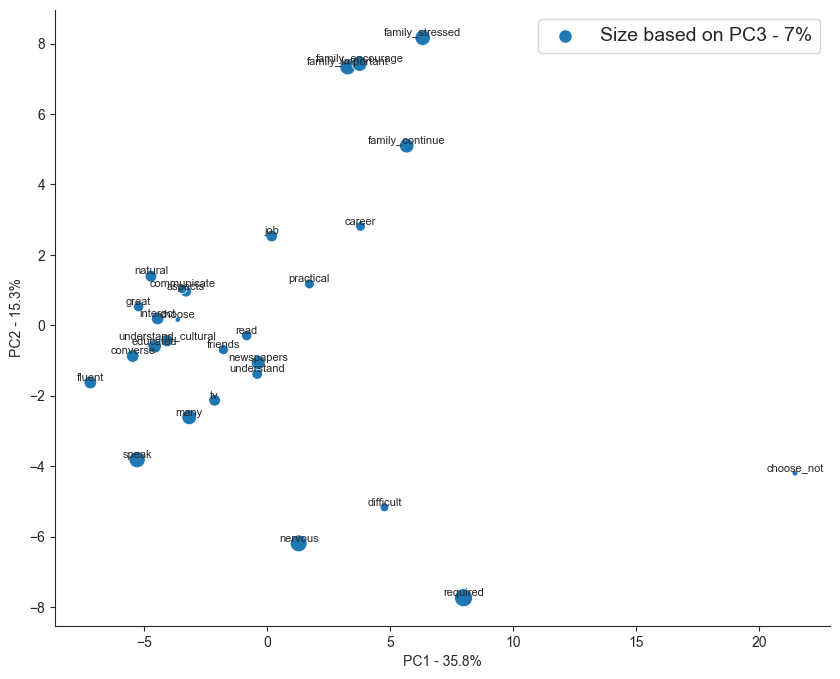

In [133]:
# Plot a 2D scatterplot of the first three principal components

# Get the minimum value of the third principal component
min_val = ques_loadings['PC3'].min()
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', 
                data=ques_loadings, 
                ax=ax, 
                s=15*(ques_loadings['PC3'] - min_val + 1))
ax.set_xlabel('PC1 - {:.1f}%'.format(variance_ratio[0] * 100))
ax.set_ylabel('PC2 - {:.1f}%'.format(variance_ratio[1] * 100))

# Add a legend saying size is based on the third principal component
ax.legend(['Size based on PC3 - {:.0f}%'.format(variance_ratio[2] * 100)], 
          loc='upper right', fontsize=14)

# Add the labels to the points
for i, txt in enumerate(ques_loadings.index):
    ax.annotate(txt, (ques_loadings['PC1'][i], ques_loadings['PC2'][i]), fontsize=8, ha='center', va='bottom')

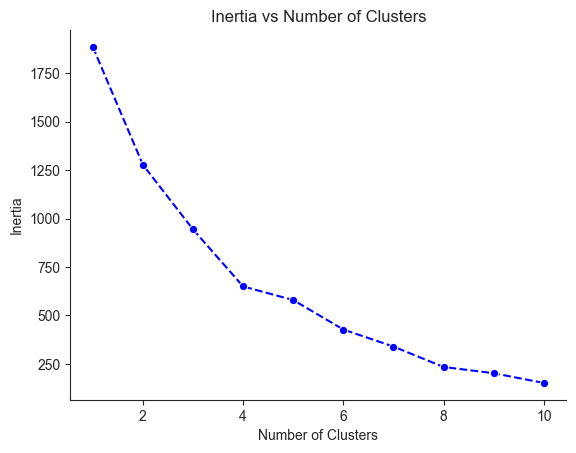

In [134]:
# Conduct a KMeans Clustering Analysis

ques_intertia = []
ques_kmeans   = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state = 42, n_init='auto')
    kmeans.fit(motivator_features_pca[:, :6])
    ques_intertia.append(kmeans.inertia_)
    ques_kmeans.append(kmeans)

# Plot the elbow plot
sns.lineplot(x=range(1, 11), y=ques_intertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.show()

In [135]:
# Create a dataframe which contains only 7 clusters
ques_kmeans7 = ques_loadings.copy()

ques_kmeans7['Cluster'] = ques_kmeans[6].labels_ + 1

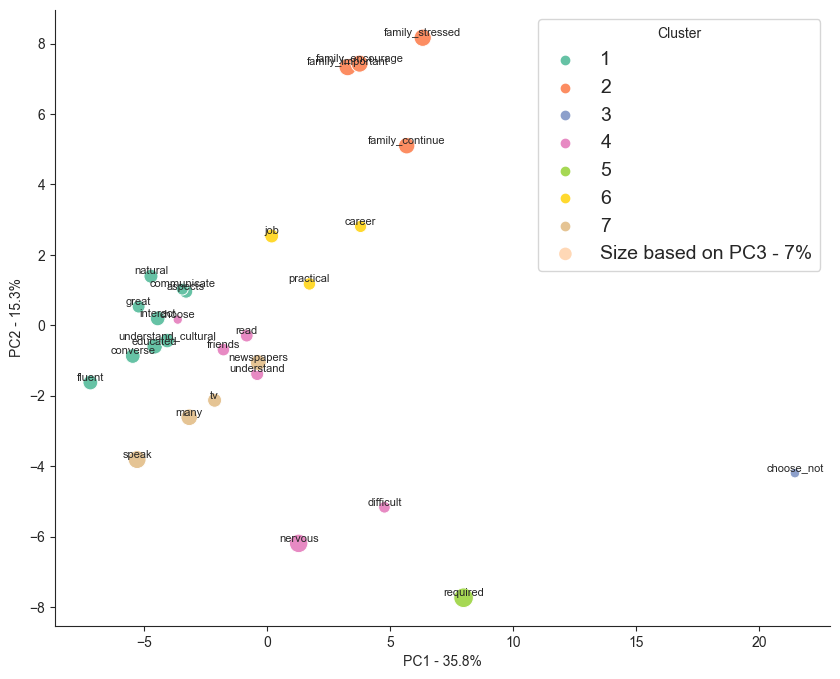

In [136]:
# Plot a 2D scatterplot of the first three principal components using the 7 clusters

# Get the minimum value of the third principal component
min_val = ques_kmeans7['PC3'].min()
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2',
                data=ques_kmeans7,
                ax=ax,
                hue='Cluster',
                palette='Set2',
                s=15*(ques_kmeans7['PC3'] - min_val + 3))
ax.set_xlabel('PC1 - {:.1f}%'.format(variance_ratio[0] * 100))
ax.set_ylabel('PC2 - {:.1f}%'.format(variance_ratio[1] * 100))

# Add an item to the legend for the size
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.scatter([],[], s=8*(ques_kmeans7['PC3'] - min_val).max(), 
                           alpha=0.3, edgecolors='none'))
labels.append('Size based on PC3 - {:.0f}%'.format(variance_ratio[2] * 100))

ax.legend(handles, labels, loc='upper right', title='Cluster', fontsize=14)

# Add the labels to the points
for i, txt in enumerate(ques_kmeans7.index):
    ax.annotate(txt, (ques_kmeans7['PC1'][i], ques_kmeans7['PC2'][i]), fontsize=8, ha='center', va='bottom')

In [137]:
def addLabels(barplot, dataframe, fontsize=8):
    """
    Adds labels to a scatterplot
    """
    for i, patch in enumerate(barplot.patches, start=1):
        cluster_list = dataframe[dataframe['Cluster'] == i].index.to_list()
        barplot.annotate('\n'.join(cluster_list),
                            (patch.get_x() + patch.get_width() / 2., patch.get_height()/2), 
                            ha = 'center', va = 'center',
                            xytext = (0, 10),
                            textcoords = 'offset points',
                            fontsize=fontsize)

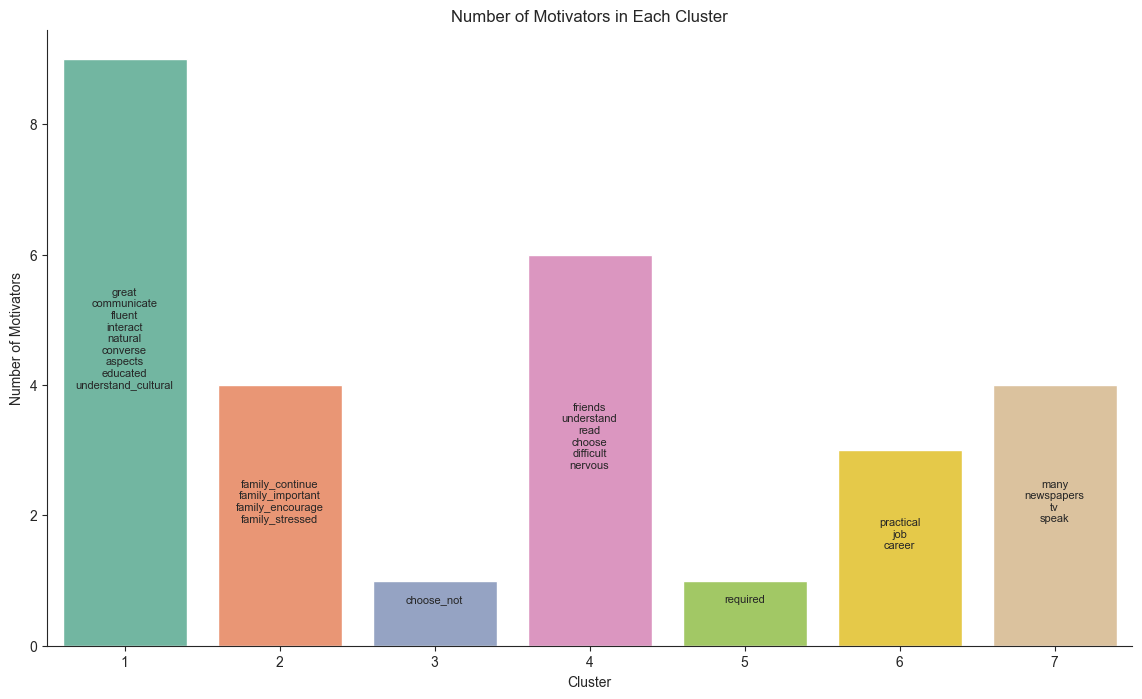

In [138]:
ques_kmeans7.sort_values(by='Cluster', inplace=True)

fig, ax = plt.subplots(figsize=(14, 8))
cluster_plt = sns.countplot(x='Cluster', data=ques_kmeans7, palette='Set2')

addLabels(cluster_plt, ques_kmeans7)
    
# Add the title and axis labels
plt.title('Number of Motivators in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Motivators')
plt.show()

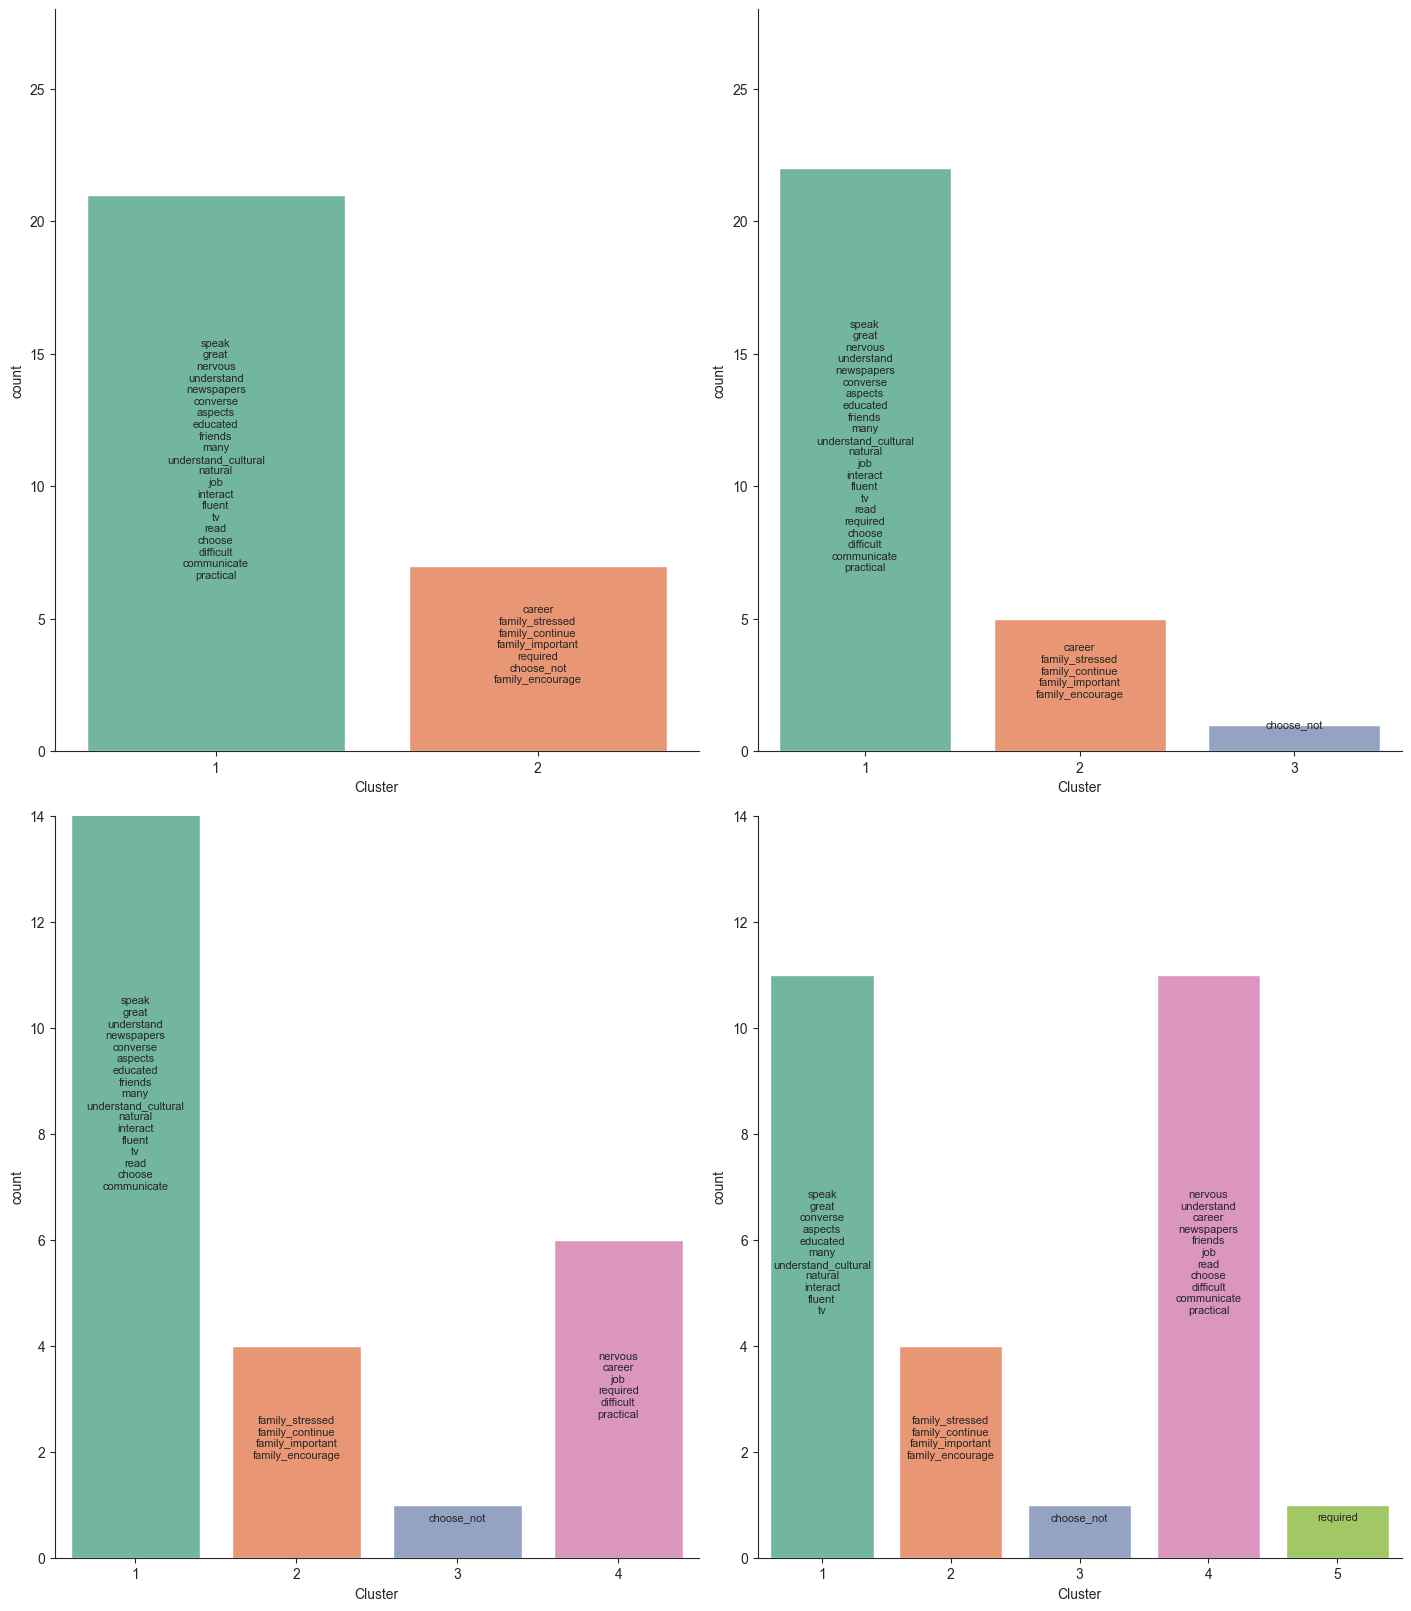

In [139]:
# Create additional count plots for 2, 3, 4, and 5 clusters
fig, ax = plt.subplots(2, 2, figsize=(14, 16), constrained_layout=True)

# Set the scale for the y-axis for all plots
ax[0, 0].set_ylim(0, 28)
ax[0, 1].set_ylim(0, 28)
ax[1, 0].set_ylim(0, 14)
ax[1, 1].set_ylim(0, 14)

# Generate the dataframe for each number of clusters
ques_means2 = ques_loadings.copy()
ques_means2['Cluster'] = ques_kmeans[1].labels_ + 1

ques_means3 = ques_loadings.copy()
ques_means3['Cluster'] = ques_kmeans[2].labels_ + 1

ques_means4 = ques_loadings.copy()
ques_means4['Cluster'] = ques_kmeans[3].labels_ + 1

ques_means5 = ques_loadings.copy()
ques_means5['Cluster'] = ques_kmeans[4].labels_ + 1

# Plot the count plots
ques2_plt = sns.countplot(x='Cluster', data=ques_means2, palette='Set2', ax=ax[0, 0])
addLabels(ques2_plt, ques_means2)

ques3_plt = sns.countplot(x='Cluster', data=ques_means3, palette='Set2', ax=ax[0, 1])
addLabels(ques3_plt, ques_means3)

ques4_plt = sns.countplot(x='Cluster', data=ques_means4, palette='Set2', ax=ax[1, 0])
addLabels(ques4_plt, ques_means4)

ques5_plt = sns.countplot(x='Cluster', data=ques_means5, palette='Set2', ax=ax[1, 1])
addLabels(ques5_plt, ques_means5)


#### Group of Participants
---
We will now conduct clustering on our participants to see the groups which arise from there and see how their responses align within these groups.

In [140]:
# Scale the data without transposing
motivators_scaled = preprocessing.scale(motivators)

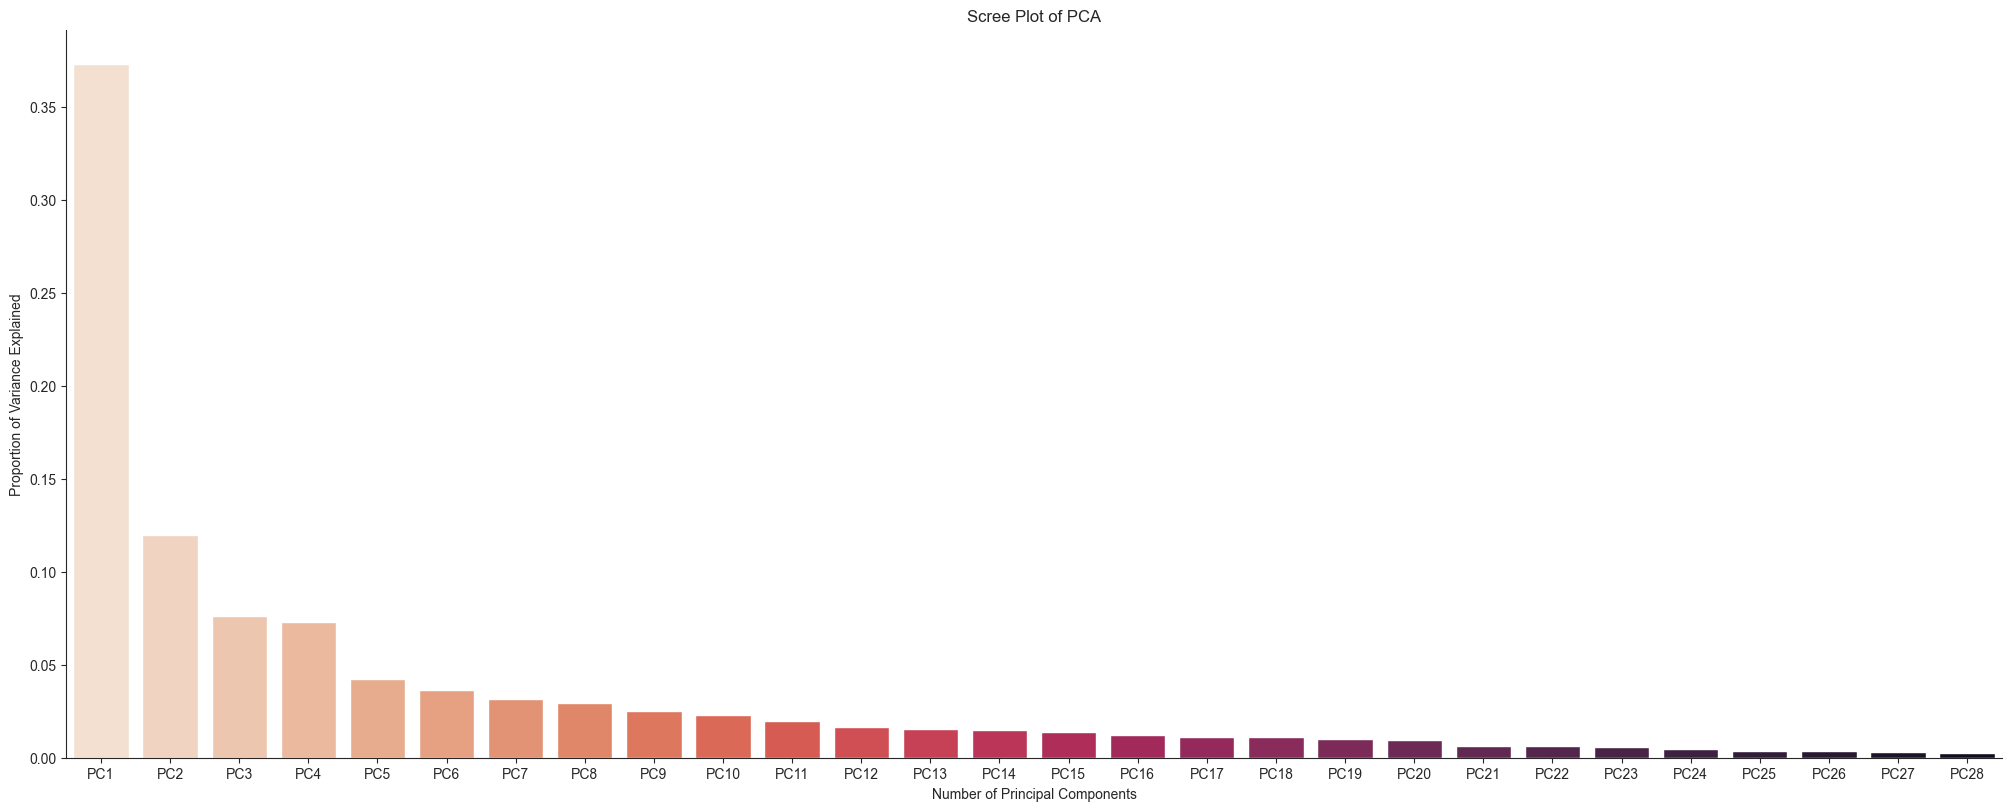

In [141]:
# Fit the PCA object to the data
pca_motivators = PCA()
pca_motivators.fit(motivators_scaled)

# Transform the data
motivators_pca = pca_motivators.transform(motivators_scaled)

# Get the variance ratio
variance_ratio = pca_motivators.explained_variance_ratio_
pca_labels = ['PC' + str(i) for i in range(1, len(variance_ratio) + 1)]

# Plot the explained variance ratio
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
sns.barplot(x=pca_labels, y=variance_ratio, palette='rocket_r')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot of PCA')
plt.show()

In [142]:
# Calculate how many components are needed to explain 90% of the variance
cumulative_variance = np.cumsum(variance_ratio)
print('Number of components needed to explain 90% of the variance: {}'.format(np.argmax(cumulative_variance >= 0.9) + 1))

Number of components needed to explain 90% of the variance: 15


In [143]:
# Create a dataframe of PCA loadings for the participants
motivators_loadings = pd.DataFrame(motivators_pca, columns=pca_labels)

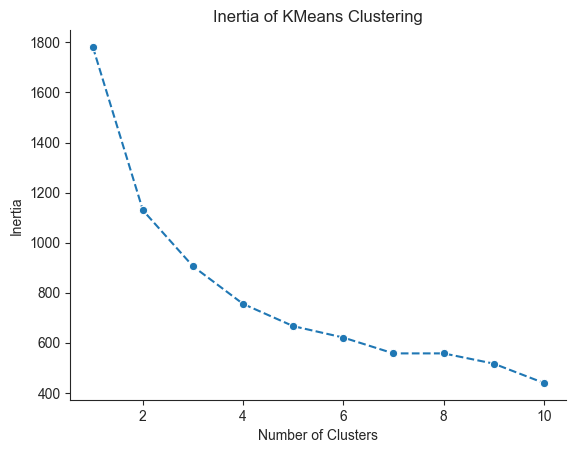

In [144]:
# Conduct a KMeans clustering analysis

ppt_inertia = []
ppt_kmeans = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(motivators_pca[:, :5])
    ppt_kmeans.append(kmeans)
    ppt_inertia.append(kmeans.inertia_)

# Plot the inertia
sns.lineplot(x=range(1, 11), y=ppt_inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans Clustering')
plt.show()

In [145]:
# Create a dataframe containing only 6 clusters
ppt_kmeans6 = motivators_loadings.copy()

ppt_kmeans6['Cluster'] = ppt_kmeans[5].labels_ + 1

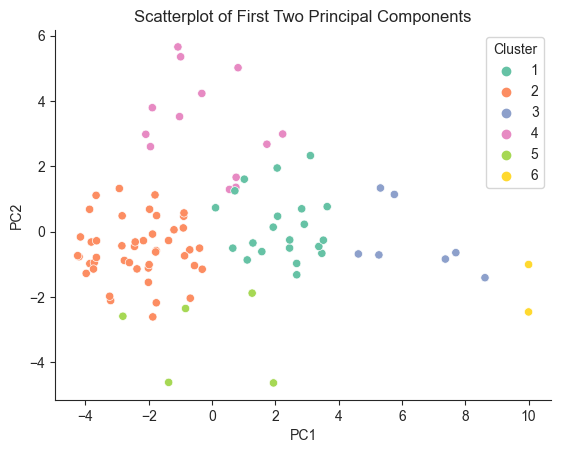

In [146]:
# Plot a scatterplot of the first two principal components
min_val = ppt_kmeans6['PC1'].min()

sns.scatterplot(x='PC1', y='PC2', data=ppt_kmeans6, hue='Cluster', palette='Set2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of First Two Principal Components')
plt.show()

In [147]:
# Place the cluster label on the original dataframe
orig_df = df.copy()

orig_df['Cluster'] = ppt_kmeans6['Cluster']

In [148]:
# Create a list of the motivation ranks
motivation_ranks = ['rank_family', 'rank_media', 'rank_education', 
                    'rank_culture', 'rank_improvement', 'rank_citizenship']

In [149]:
# Melt the dataframe down to long format
orig_df_melt = pd.melt(orig_df, id_vars=['Cluster'], value_vars=motivation_ranks)

# Rename the variables column
orig_df_melt.rename(columns={'variable': 'Motivation', 'value': 'Rank'}, inplace=True)

# Rename the values within the motivation column
orig_df_melt['Motivation'].replace({'rank_family': 'Family', 'rank_media': 'Media',
                                    'rank_culture': 'Culture', 'rank_improvement': 'Improvement',
                                    'rank_citizenship': 'Citizenship', 'rank_education': 'Education'}, inplace=True)

In [150]:
# Keep only the first clusters 
orig_df_short_first = orig_df_melt[orig_df_melt['Cluster'] <= 3]

# Keep the last clusters
orig_df_short_last = orig_df_melt[orig_df_melt['Cluster'] > 3]

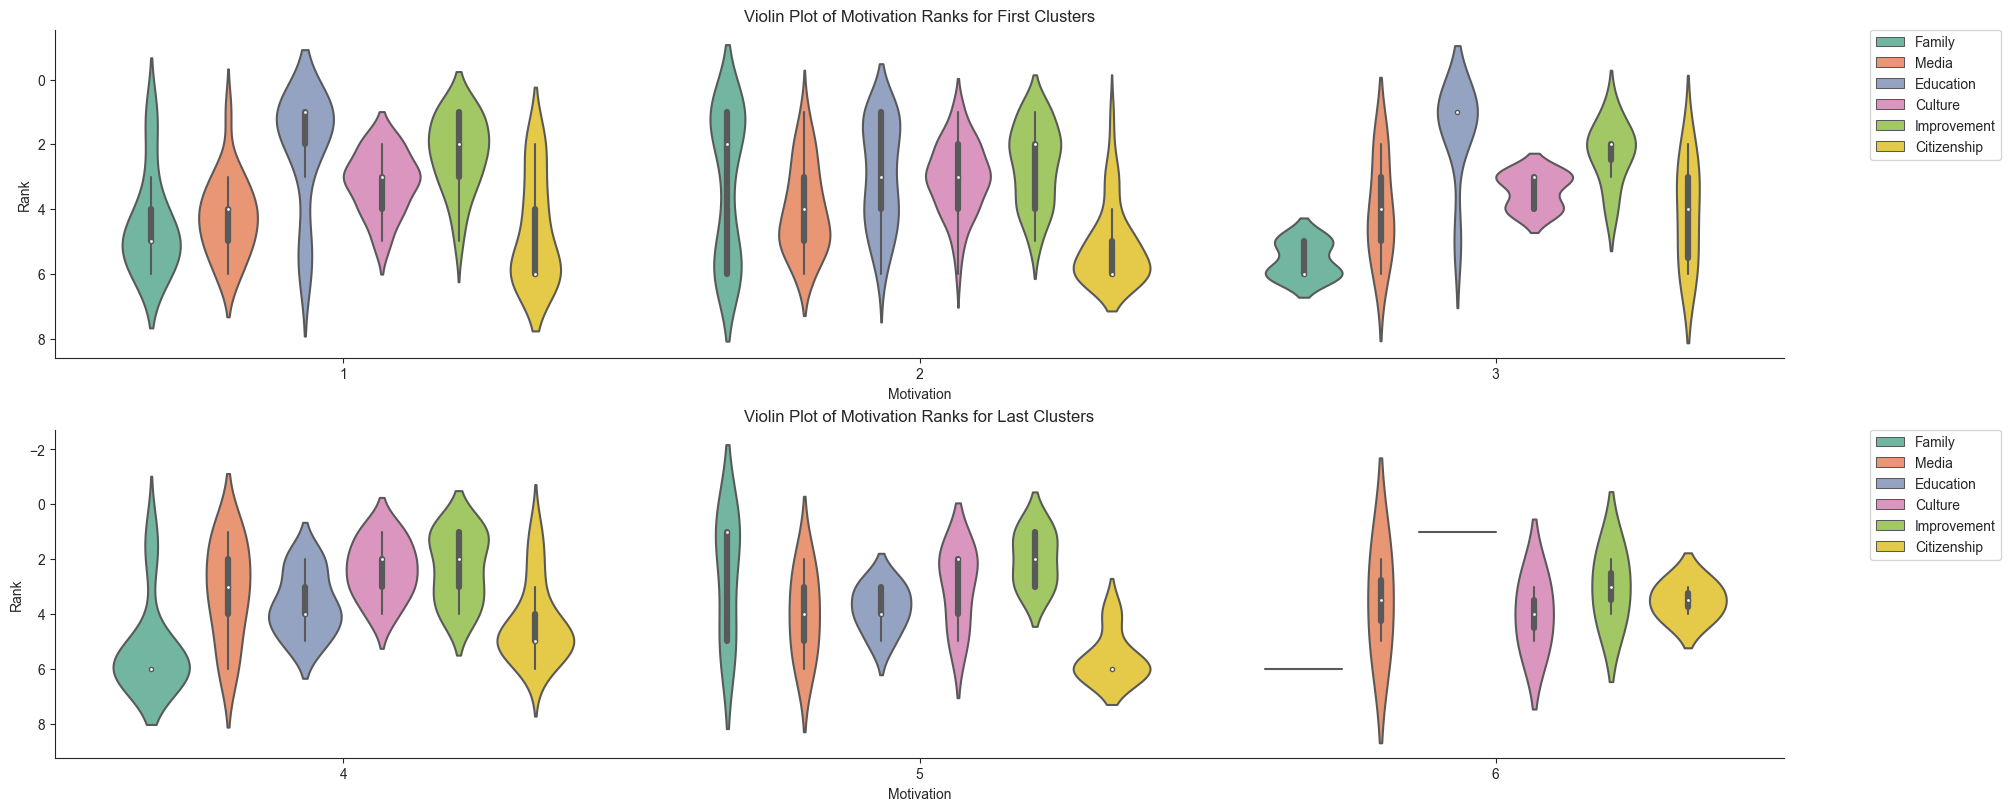

In [151]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), constrained_layout=True)

# Plot the first clusters
sns.violinplot(x='Cluster', y='Rank', data=orig_df_short_first, hue='Motivation', palette='Set2', ax=ax[0])

ax[0].set_title('Violin Plot of Motivation Ranks for First Clusters')
ax[0].set_xlabel('Motivation')
ax[0].set_ylabel('Rank')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot the last clusters
sns.violinplot(x='Cluster', y='Rank', data=orig_df_short_last, hue='Motivation', palette='Set2', ax=ax[1])
ax[1].set_title('Violin Plot of Motivation Ranks for Last Clusters')
ax[1].set_xlabel('Motivation')
ax[1].set_ylabel('Rank')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Reverse the order of the y-axis
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()